### notebook purpose

- compare joint recon of both echos to individual recon
    - currently, joint recon method is just concatenating echo1, echo2
    - preliminary results: helps significantly on echo2, negligible on echo1

In [2]:
import os, sys
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import normalize

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, norm_imgs

In [3]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

# def compute_diff_map(im1, im2, c=4, norm='l1'):
# #     im1 = normalize(im1, axis=1, norm=norm)
# #     im2 = normalize(im2, axis=1, norm=norm)
#     diff = im1/im1.max() - im2/im2.max()
#     diff = diff - diff.min()
#     return c * diff # c*(im1-im2)

def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

In [31]:
id_list = ['005', '006', '030', '034', '048', '052', '065',
           '080', '096', '099', '120', '144', '156', '158']#,
#            '176', '178', '188', '196', '198', '199', '218', '219', 
#            '221', '223', '224', '227', '235', '237', '240', '241',
#            '244', '248']

# deleted: '066', '173'

### currently running joint recons over accel={4,8}
- confirm the joint recon w new_layers method doesn't have checkerboard artifacts like shared_layers method
    - assuming this, delete old data and move in new data from `new_layers/`
- confirm similar quant performance boost to slides i sent akshay on 20210121. assuming echo_joint recon is better for both echo1 and echo2...
    - delete echo1, echo2 data. delete echoX script. clean up echo_joint script + file naming convention
- assuming both above are confirmed...
    - clean up this thread in roam
    - clean up scripts, merge dev to master
    - onward and upward!

In [34]:
e_num_list = [1,2]
accel_list = [4,8]

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_VARS = 4
NUM_METRICS = 4

for accel in accel_list:

    path_ej = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/'.format(accel)

    metrics_sep = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_joint = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, 512, 160))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):
            
            path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

            im_gt = np.load('{}echo{}/new_layers/MTR_{}_gt.npy'.format(path_q, e_num, id_))  
            im_gt_j = np.load('{}MTR_{}_e{}_gt.npy'.format(path_ej, id_, e_num))
            if abs(im_gt - im_gt_j).max() != 0:
                raise ValueError('ground-truths do not match for MTR_{}'.format(id_))
                continue

            im_dc = np.load('{}echo{}/new_layers/MTR_{}_dc.npy'.format(path_q, e_num, id_))
            im_dc_j = np.load('{}MTR_{}_e{}-joint-recon_dc.npy'.format(path_ej, id_, e_num))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc, im_dc_j = im_gt/im_gt.max(), im_dc/im_dc.max(), im_dc_j/im_dc_j.max()

            metrics_sep[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_joint[idx_e][idx] = calc_metrics(im_gt, im_dc_j)

            C = 4
            im_diff = C * (im_dc - im_dc_j)
            
            im_list[idx][idx_e] = np.array([im_gt, im_dc, im_dc_j, im_diff])

    perc_diff_list = (metrics_joint - metrics_sep) / metrics_sep

    vals_sep = np.mean(metrics_sep, axis=1)
    vals_joint = np.mean(metrics_joint, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
    print('accel {}x \n'.format(accel))
    print('recon sep')
    print(vals_sep, '\n')
    print('recon joint')
    print(vals_joint, '\n')
    print('perc diff')
    print(perc_diff)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

accel 4x 

recon sep
[[ 0.909  0.968  0.853 32.809]] 

recon joint
[[ 0.915  0.974  0.879 33.373]] 

perc diff
[[0.007 0.006 0.031 0.017]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [ ]:
## COPIED_LAYERS

accel 4x 

recon sep
[[ 0.91   0.967  0.851 32.762]
 [ 0.815  0.922  0.739 31.88 ]] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accel 8x 

recon sep
[[ 0.863  0.955  0.806 30.516]
 [ 0.747  0.897  0.685 30.505]] 



## NEW_LAYERS

accel 4x 

recon sep
[[ 0.913  0.973  0.876 33.354]
 [ 0.789  0.929  0.755 32.297]] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accel 8x 

recon sep
[[ 0.857  0.962  0.829 30.793]
 [ 0.725  0.907  0.706 30.879]] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

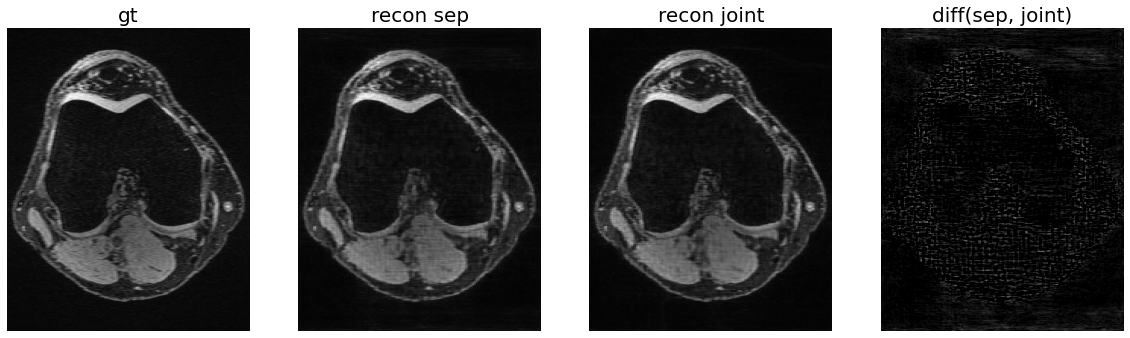

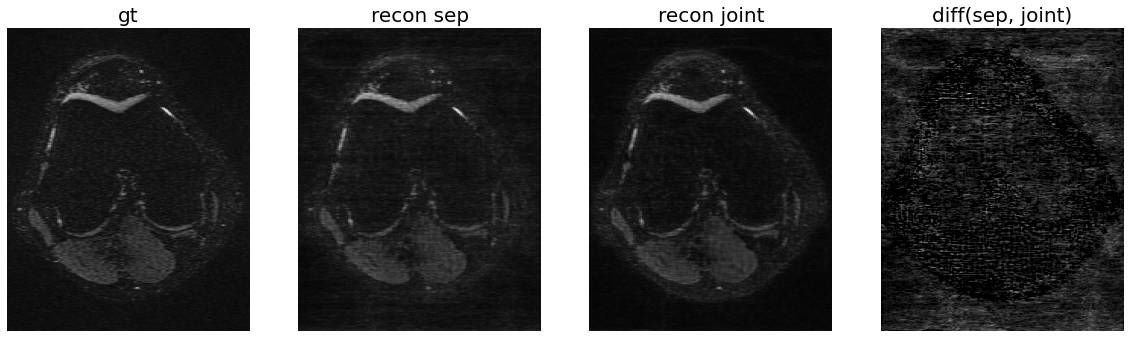

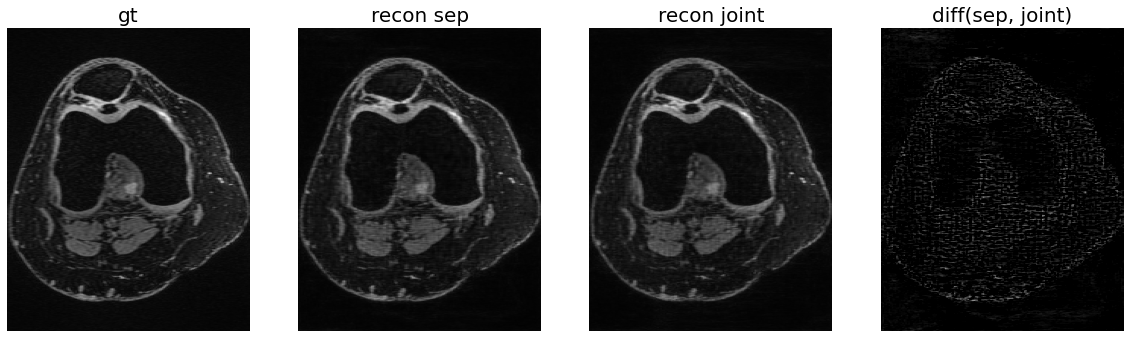

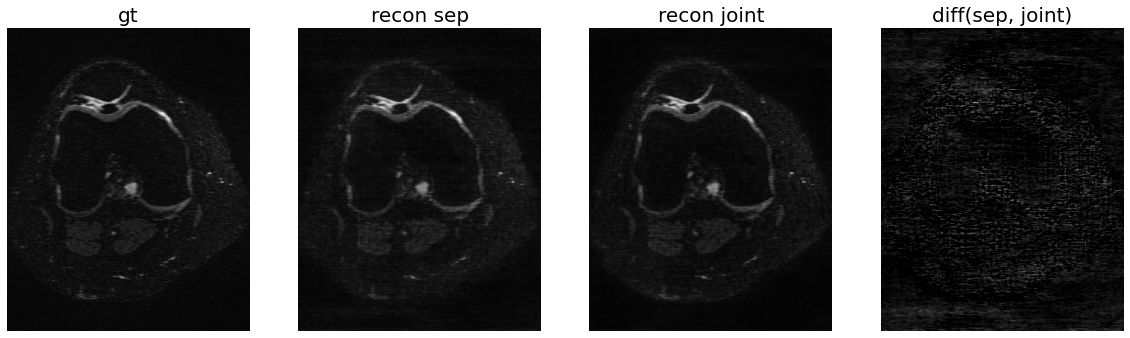

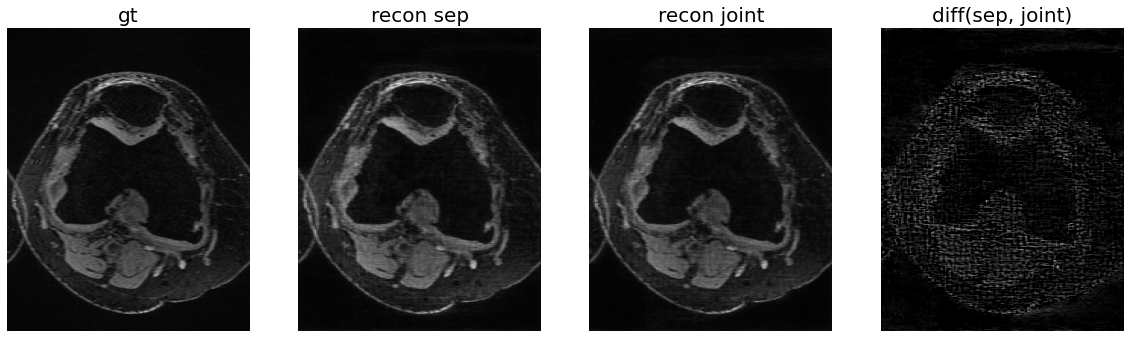

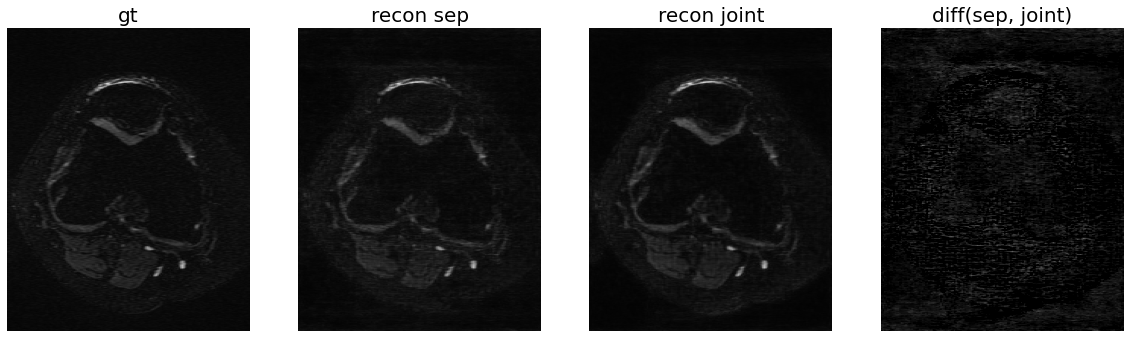

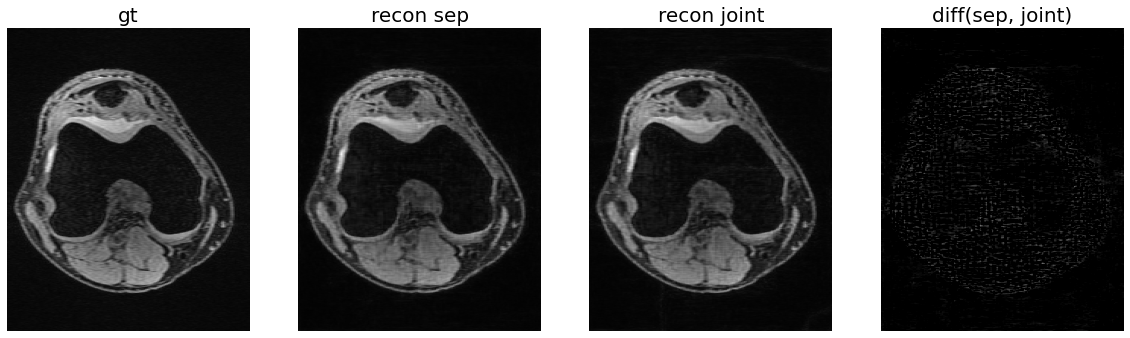

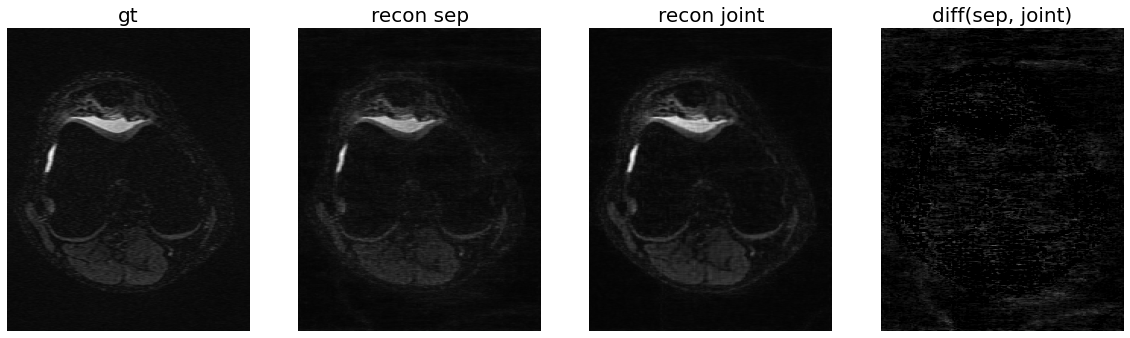

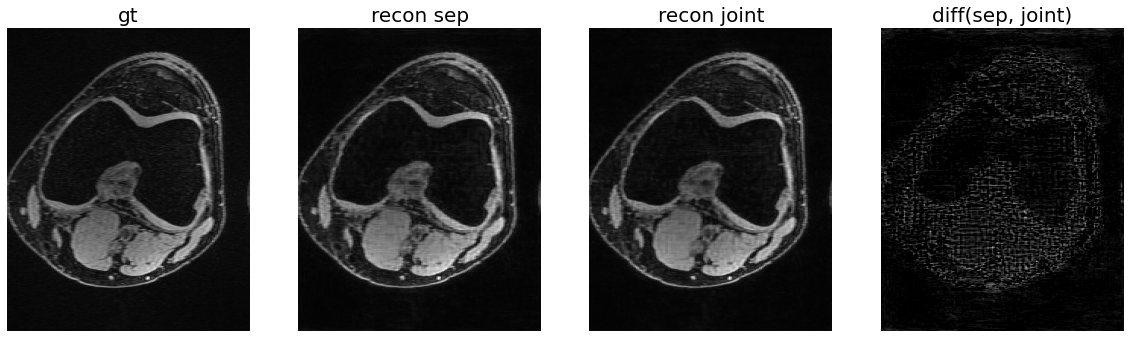

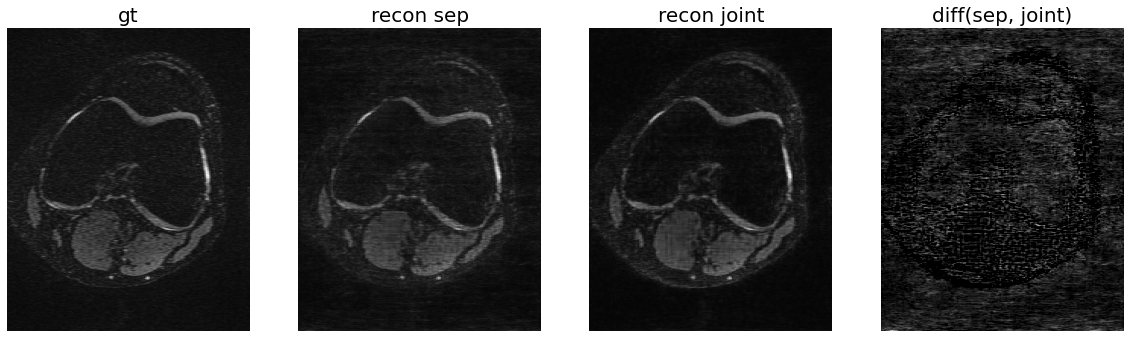

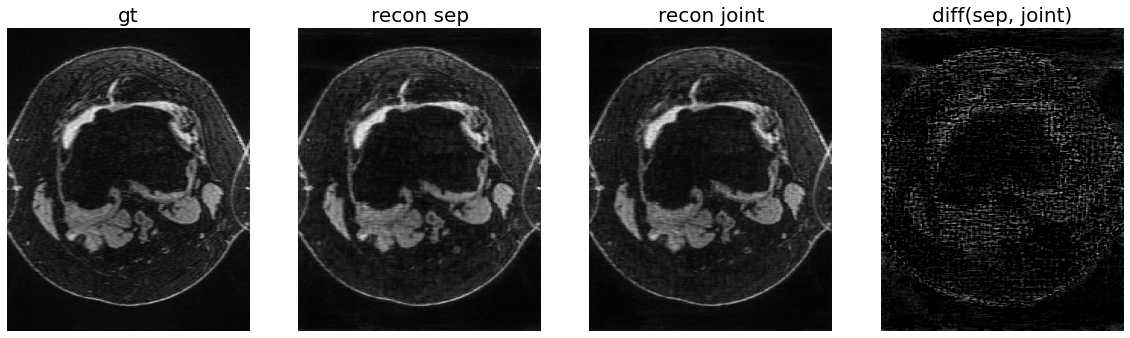

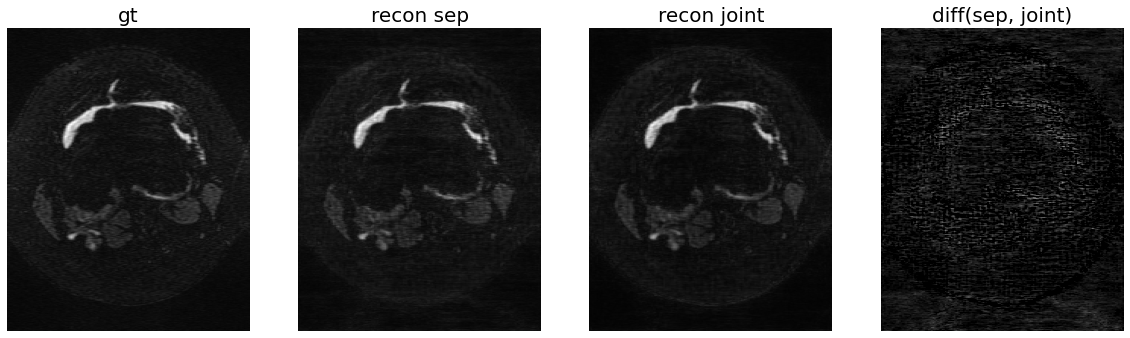

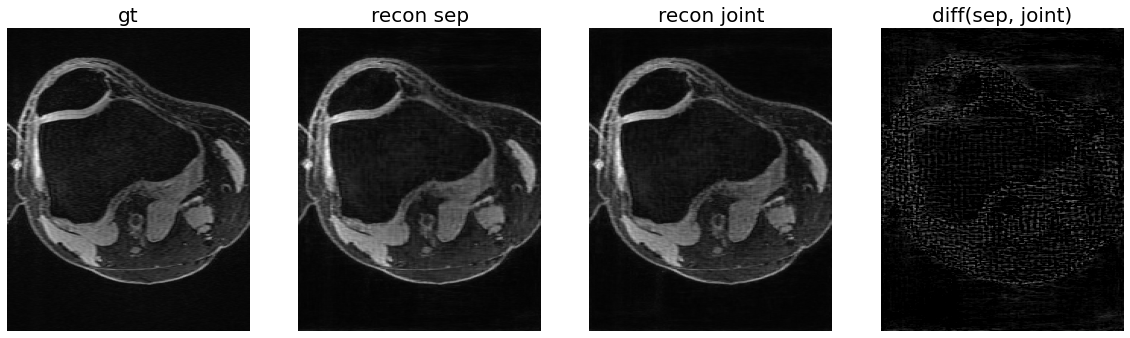

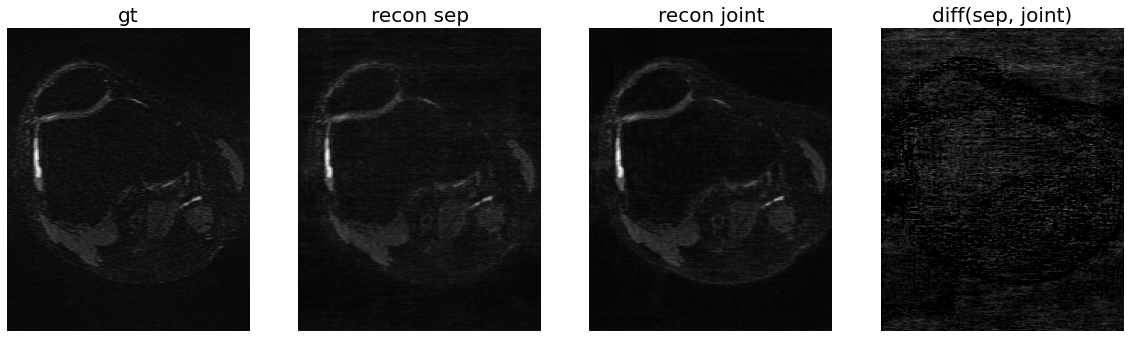

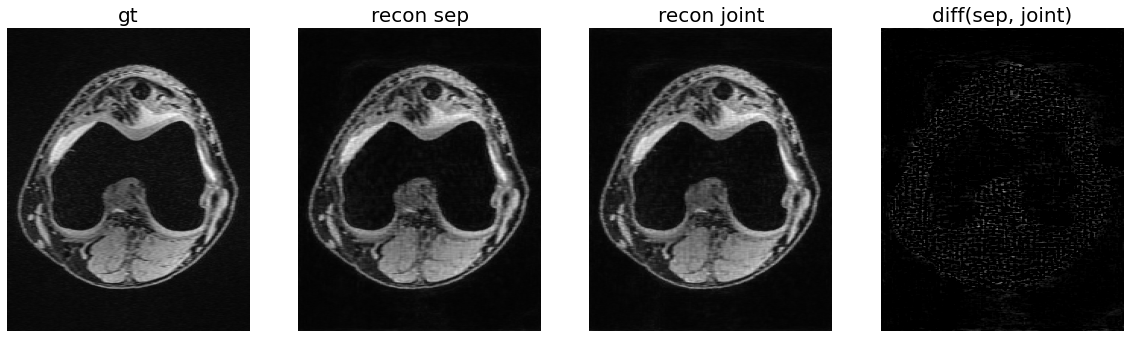

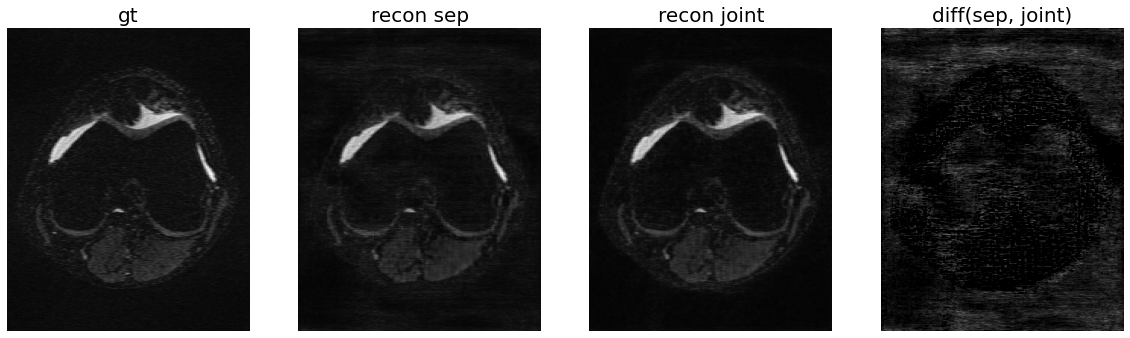

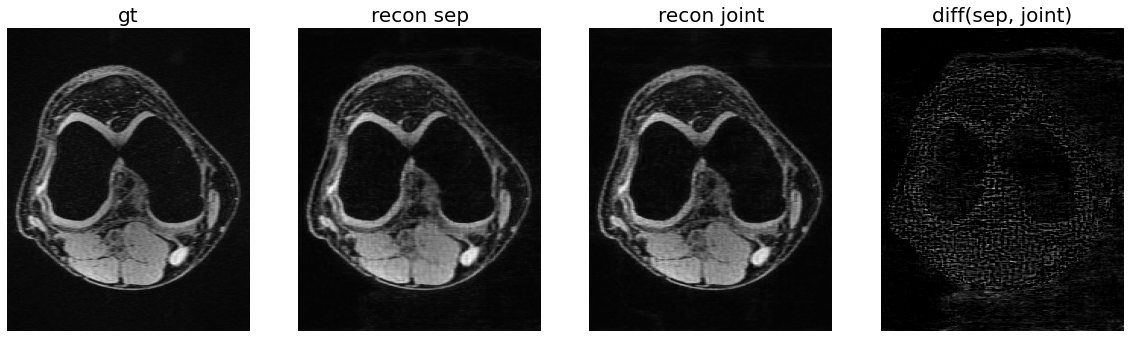

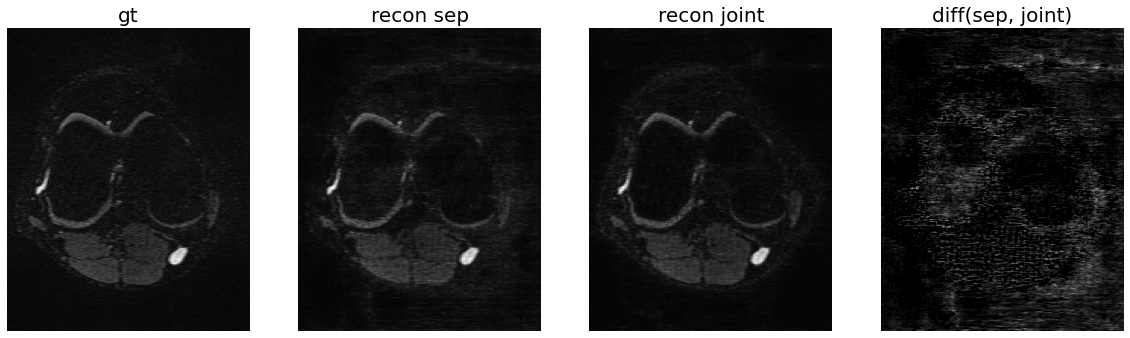

In [19]:
title_list = ['gt', 'recon sep', 'recon joint', 'diff(sep, joint)']

for idx_s, _ in enumerate(im_list):
    for e in im_list[idx_s]:
        plot_list(e, title_list)

num_params without stacked: 233280, with stacked: 235840

shape without: [(15, 7), (27, 12), (48, 20), (87, 33), (157, 56), (283, 95), torch.Size([512, 160])]

shape with: [(15, 7), (27, 12), (48, 20), (87, 33), (157, 56), (283, 95), torch.Size([512, 160])]

# DELETE ME BELOW

- originally, this script was built to compare individual vs joint recon across echo={1,2}, accel={4,8}
- now, it has been temporarily modified to compare network architecture: copied vs new layers
    - if `COMP_NEW_V_COPIED_LAYERS` = True: prints results across echos, accels for architecture w new layers
    - if -------------------------- = False: ----------------------------------------------------- copied layers
    - on echo1, accel4, it appeared to make no difference. note this doesn't agree w fastmri results
    
##### TODO after this experiment is done
- currently running this on all combinations of echo={1,2} and accel={4,8} + echo_joint/accel4
- depending which is better, either delete `new_layers/` subdirectory or replace the original w those contents
- edit this script accordingly

In [ ]:
COMP_NEW_V_COPIED_LAYERS = False

e_num_list = [1,2]
accel_list = [4,8]

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_VARS = 4
NUM_METRICS = 4

for accel in accel_list:

    path_ej = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/'.format(accel)

    metrics_sep = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_joint = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, 512, 160))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):
            
            if COMP_NEW_V_COPIED_LAYERS:
                path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo{}/new_layers/'.format(accel, e_num)
            else:
                path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

            if COMP_NEW_V_COPIED_LAYERS:
                im_gt = np.load('{}MTR_{}_gt.npy'.format(path_q, id_))
                im_dc = np.load('{}MTR_{}_dc.npy'.format(path_q, id_))
            else:
                im_gt = np.load('{}echo{}/MTR_{}_gt.npy'.format(path_q, e_num, id_))            
                im_gt_j = np.load('{}MTR_{}_e{}_gt.npy'.format(path_ej, id_, e_num))

                if abs(im_gt - im_gt_j).max() != 0:
                    raise ValueError('ground-truths do not match for MTR_{}'.format(id_))
                    continue

                im_dc = np.load('{}echo{}/MTR_{}_dc.npy'.format(path_q, e_num, id_))

            im_dc_j = np.load('{}MTR_{}_e{}-joint-recon_dc.npy'.format(path_ej, id_, e_num))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc, im_dc_j = im_gt/im_gt.max(), im_dc/im_dc.max(), im_dc_j/im_dc_j.max()

            metrics_sep[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_joint[idx_e][idx] = calc_metrics(im_gt, im_dc_j)

            C = 4
            im_diff = C * (im_dc - im_dc_j)
            
            im_list[idx][idx_e] = np.array([im_gt, im_dc, im_dc_j, im_diff])

    perc_diff_list = (metrics_joint - metrics_sep) / metrics_sep

    vals_sep = np.mean(metrics_sep, axis=1)
    vals_joint = np.mean(metrics_joint, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
    print('accel {}x \n'.format(accel))
    print('recon sep')
    print(vals_sep, '\n')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')